Import the necessary libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


Load the processed data

In [65]:
df = pd.read_csv("../data/processed/processed-data.csv")

print("Shape:", df.shape)
df.head()

Shape: (10726, 18)


,trip_id,stop_sequence,stop_id,arrival_time,departure_time,stop_lat,stop_lon,stop_name,route_id,service_id,direction_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,WE_1,1,TPHT,22:50:19,22:52:41,9.950780,76.351830,Tripunithura,R1,WE,1,0,0,0,0,0,0,1
1,WE_1,2,SNJN,22:54:30,22:54:45,9.954753,76.345850,SN Junction,R1,WE,1,0,0,0,0,0,0,1
2,WE_1,3,VAKK,22:56:08,22:56:23,9.952838,76.339483,Vadakkekotta,R1,WE,1,0,0,0,0,0,0,1
3,WE_1,4,PETT,22:58:35,22:58:50,9.952484,76.330210,Pettah,R1,WE,1,0,0,0,0,0,0,1
4,WE_1,5,THYK,23:00:43,23:00:58,9.960031,76.323676,Thykoodam,R1,WE,1,0,0,0,0,0,0,1


Time Feature Engineering

In [66]:
df['hour'] = (
    df['arrival_time']
    .astype(str)
    .str.split(':')
    .str[0]
    .astype(int)
    % 24
)

df['day_of_week'] = (
    df[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]
    .idxmax(axis=1)
)

df['is_weekend'] = df['day_of_week'].isin(['saturday', 'sunday']).astype(int)

df[['hour','day_of_week','is_weekend']].head()


,hour,day_of_week,is_weekend
0,22,sunday,1
1,22,sunday,1
2,22,sunday,1
3,22,sunday,1
4,23,sunday,1


Peak hour feature

In [67]:
df['is_peak_hour'] = df['hour'].apply(
    lambda h: 1 if (8 <= h <= 10 or 17 <= h <= 20) else 0
)

Train Frequency

In [68]:
train_freq = (
    df.groupby(['stop_id', 'hour'])
    .agg(trains_per_hour=('trip_id', 'nunique'))
    .reset_index()
)

df = df.merge(train_freq, on=['stop_id', 'hour'], how='left')

df['trains_per_hour'] = df['trains_per_hour'].fillna(1)


Estimated Demand

In [69]:
np.random.seed(42)

df['estimated_demand'] = (
    20 +
    df['is_peak_hour'] * 60 +
    df['trains_per_hour'] * 15 +
    (1 - df['is_weekend']) * 10 +
    np.random.normal(0, 5, len(df))
)

df['estimated_demand'] = df['estimated_demand'].clip(lower=5)
df.isna().sum()



trip_id             0
stop_sequence       0
stop_id             0
arrival_time        0
departure_time      0
stop_lat            0
stop_lon            0
stop_name           0
route_id            0
service_id          0
direction_id        0
monday              0
tuesday             0
wednesday           0
thursday            0
friday              0
saturday            0
sunday              0
hour                0
day_of_week         0
is_weekend          0
is_peak_hour        0
trains_per_hour     0
estimated_demand    0
dtype: int64

Preprocessed data

In [70]:
features = [
    'hour',
    'is_weekend',
    'is_peak_hour',
    'trains_per_hour',
    'direction_id'
]

X = df[features].fillna(0)
y = df['estimated_demand'].fillna(df['estimated_demand'].mean())

Train-Test Split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Model Training

In [72]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluate the model

In [73]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", round(mae, 2))


Mean Absolute Error: 4.13


Feature Importance

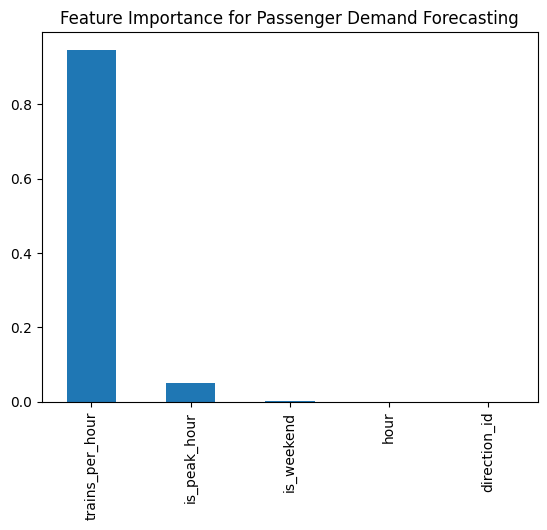

In [74]:
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(
    kind='bar',
    title='Feature Importance for Passenger Demand Forecasting'
)
plt.show()


Demo Forecast

In [75]:
sample_input = pd.DataFrame([{
    'hour': 9,
    'is_weekend': 0,
    'is_peak_hour': 1,
    'trains_per_hour': 6,
    'direction_id': 0
}])

predicted_demand = model.predict(sample_input)
print("Predicted Passenger Demand:", int(predicted_demand[0]))


Predicted Passenger Demand: 120
